# Skin cancer classification challenge

**Summary :** Skin cancer classification

## Preliminaries and Imports

In [1]:
import json
import collections
from PIL import Image
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = 10, 10  #default setting
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline

## I. Load metadata

- **Rq : ** Datasets are quite light, can be fully loaded in a laptop memory with ease.

In [2]:
#Set all paths for data
main_path = "../ISIC-images/"
resized_folder = "../data/resized"
folders = os.listdir(main_path)

#create a target forlder for resized pictures
if not os.path.exists(resized_folder):
    os.makedirs(resized_folder)

In [3]:
%%time
temp = []
for folder in folders:
    files = os.listdir(main_path+"/"+folder)
    for element in files :
        if ".json" in element:
            with open(main_path+"/"+folder+"/"+element) as json_data:
                d = json.load(json_data)
                d["folder"]=folder
            temp.append(d)

CPU times: user 64 ms, sys: 216 ms, total: 280 ms
Wall time: 1.08 s


In [4]:
def flatten_dic(d, parent_key='', sep='_'):
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, collections.MutableMapping):
            items.extend(flatten_dic(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

In [5]:
%%time
#flatten the meta key:
temp = map(flatten_dic,temp)

CPU times: user 72 ms, sys: 4 ms, total: 76 ms
Wall time: 90.2 ms


In [6]:
#format as dataframe
meta = pd.DataFrame(temp)
meta.head()

,_id,folder,meta_acquisition_image_type,meta_acquisition_pixelsX,meta_acquisition_pixelsY,meta_clinical_age_approx,meta_clinical_benign_malignant,meta_clinical_diagnosis,meta_clinical_diagnosis_confirm_type,meta_clinical_melanocytic,meta_clinical_sex,name
0,5825fda49fc3c171066d3554,ISIC_MSK-5_1,dermoscopic,2592,1936,75.0,benign,seborrheic keratosis,single image expert consensus,False,male,ISIC_0014621
1,5825fda49fc3c171066d355d,ISIC_MSK-5_1,dermoscopic,2592,1936,75.0,benign,seborrheic keratosis,single image expert consensus,False,male,ISIC_0014622
2,5825fda59fc3c171066d3566,ISIC_MSK-5_1,dermoscopic,2592,1936,75.0,benign,seborrheic keratosis,single image expert consensus,False,male,ISIC_0014623
3,5825fda59fc3c171066d356f,ISIC_MSK-5_1,dermoscopic,2592,1936,75.0,benign,seborrheic keratosis,single image expert consensus,False,male,ISIC_0014624
4,5825fda69fc3c171066d3578,ISIC_MSK-5_1,dermoscopic,2592,1936,75.0,benign,seborrheic keratosis,single image expert consensus,False,male,ISIC_0014625


In [7]:
#saving file:
meta.to_csv("../data/metadata.csv",index=False)

- **Data integrity check**

In [8]:
#data integrity check
#variable types
def summaryze(df):
    summary =  pd.DataFrame()
    summary["column"] = list(df.columns)
    summary["type"] = list(df.dtypes)
    summary["nb_missing_values"] = list(df.isnull().sum())
    summary["nb_missing_values%"] = summary["nb_missing_values"]/len(df)*100
    summary.set_index("column",inplace=True)
    return summary

In [9]:
summaryze(meta)

,type,nb_missing_values,nb_missing_values%
column,,,
_id,object,0,0.000000
folder,object,0,0.000000
meta_acquisition_image_type,object,0,0.000000
meta_acquisition_pixelsX,int64,0,0.000000
meta_acquisition_pixelsY,int64,0,0.000000
meta_clinical_age_approx,float64,272,37.362637
meta_clinical_benign_malignant,object,0,0.000000
meta_clinical_diagnosis,object,2,0.274725
meta_clinical_diagnosis_confirm_type,object,398,54.670330


> ** First interpretations : **
- Image datas are stored in band_1 and band_2 as matrix
- Training set contains only 1 604 rows... warning! Data augmentation and other tricks are to be considered.
- Inc_angle nature (?)

In [10]:
#size ratio
#set(meta.meta_acquisition_pixelsX/meta.meta_acquisition_pixelsY)

# II. Colour auto croping

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
import numpy as np
import cv2
from sklearn import preprocessing
from sklearn.metrics.pairwise import euclidean_distances
from skimage import io
from sklearn.cluster import KMeans

/home/paul/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


(3872, 2592)


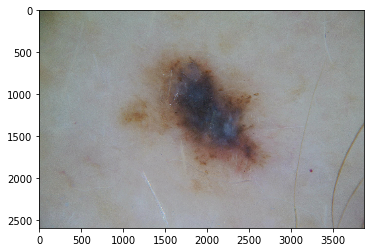

In [12]:
#resized pictures
test_picture = '../ISIC-images/ISIC_UDA-2_1/ISIC_0001103.jpg'
img = Image.open(test_picture)
plt.imshow(img)
print(img.size)

In [13]:
def kmeans_image(picture_path,k=4,resize_ratio=0.3):
    img = cv2.imread(picture_path)
    img = cv2.resize(img, (0,0), fx=resize_ratio, fy=resize_ratio)
    Z = img.reshape((-1,3))

    # convert to np.float32
    Z = np.float32(Z)

    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = k
    ret,label,center=cv2.kmeans(Z,K,None,criteria,5,cv2.KMEANS_RANDOM_CENTERS)

    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    res = center[label.flatten()]
    res = res.reshape((img.shape))

    #plt.imshow(res)
    return res,center

def kmeans_image_v2(picture_path,k=4,resize_ratio=0.3):
    img = cv2.imread(picture_path)
    img = cv2.resize(img, (0,0), fx=resize_ratio, fy=resize_ratio)
    rows = img.shape[0]
    cols = img.shape[1]
    Z = img.reshape((-1,3))
    # convert to np.float32
    Z = np.float32(Z)
    #image = image.reshape(image.shape[0]*image.shape[1],3)
    kmeans = KMeans(n_clusters = k, n_init=5, max_iter=100, tol=0.01,n_jobs = 4)
    kmeans.fit(Z)

    clusters = np.asarray(kmeans.cluster_centers_,dtype=np.uint8) 
    labels = np.asarray(kmeans.labels_,dtype=np.uint8 )  
    res = clusters[labels.flatten()]
    res = res.reshape((img.shape))
    #plt.imshow(res)
    return res,clusters



In [14]:
%%time
test,clusters = kmeans_image(test_picture,k=4,resize_ratio=0.3)

CPU times: user 1.57 s, sys: 52 ms, total: 1.62 s
Wall time: 914 ms


In [15]:
%%time
test,clusters = kmeans_image_v2(test_picture,k=4,resize_ratio=0.3)

CPU times: user 452 ms, sys: 104 ms, total: 556 ms
Wall time: 2.28 s


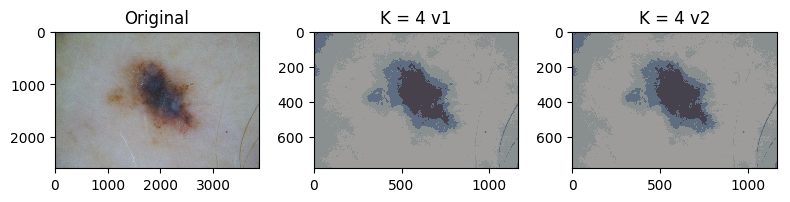

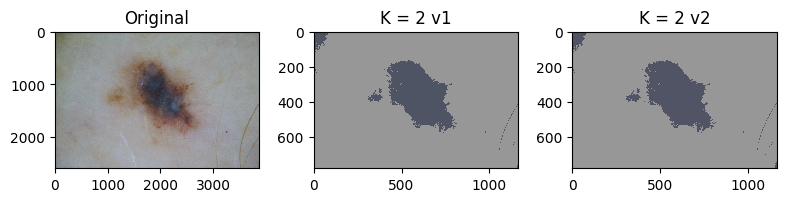

CPU times: user 4.91 s, sys: 1.98 s, total: 6.89 s
Wall time: 6.45 s


In [16]:
%%time
#plot description
plt.figure(figsize=(8,7),dpi=100)
plt.subplot(2, 3, 1)
img = Image.open(test_picture)
plt.imshow(img)
plt.title("Original")


plt.subplot(2, 3, 2)
test,clusters = kmeans_image(test_picture,k=4,resize_ratio=0.3)
plt.imshow(test)
plt.title("K = 4 v1")


#plot description
plt.subplot(2, 3, 3) 
test,clusters = kmeans_image_v2(test_picture,k=4,resize_ratio=0.3)
plt.imshow(test)
plt.tight_layout()
plt.title("K = 4 v2")
plt.show()

plt.figure(figsize=(8,7),dpi=100)
plt.subplot(2, 3, 4)
img = Image.open(test_picture)
plt.imshow(img)
plt.title("Original")


plt.subplot(2, 3, 5)
test,clusters = kmeans_image(test_picture,k=2,resize_ratio=0.3)
plt.imshow(test)
plt.title("K = 2 v1")


#plot description
plt.subplot(2, 3, 6) 
test,clusters = kmeans_image_v2(test_picture,k=2,resize_ratio=0.3)
plt.imshow(test)
plt.tight_layout()
plt.title("K = 2 v2")
plt.show()


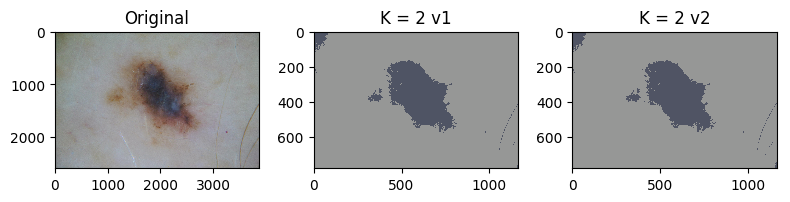

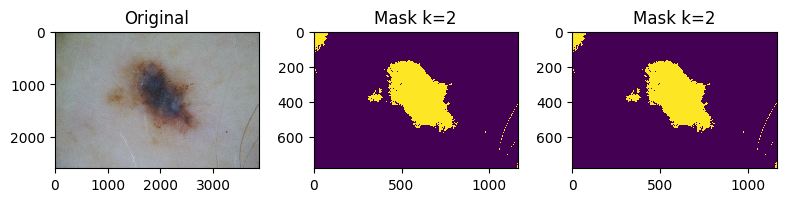

CPU times: user 4.14 s, sys: 2.02 s, total: 6.16 s
Wall time: 5.38 s


In [22]:
%%time
#plot description
plt.figure(figsize=(8,7),dpi=100)
plt.subplot(2, 3, 1)
img = Image.open(test_picture)
plt.imshow(img)
plt.title("Original")


plt.subplot(2, 3, 2)
test,clusters = kmeans_image(test_picture,k=2,resize_ratio=0.3)
plt.imshow(test)
plt.title("K = 2 v1")


#plot description
plt.subplot(2, 3, 3) 
test,clusters = kmeans_image_v2(test_picture,k=2,resize_ratio=0.3)
plt.imshow(test)
plt.tight_layout()
plt.title("K = 2 v2")
plt.show()

plt.figure(figsize=(8,7),dpi=100)
plt.subplot(2, 3, 4)
img = Image.open(test_picture)
plt.imshow(img)
plt.title("Original")


plt.subplot(2, 3, 5)
test,clusters = kmeans_image(test_picture,k=2,resize_ratio=0.3)
lower = clusters.min(axis = 0)
upper = lower+1
#test = cv2.GaussianBlur(test, (10,10),0)
mask = cv2.inRange(test,lower,upper)
plt.imshow(mask)
plt.title("Mask k=2")


#plot description
plt.subplot(2, 3, 6) 
test,clusters = kmeans_image_v2(test_picture,k=2,resize_ratio=0.3)
lower = clusters.min(axis = 0)
upper = lower+1
mask = cv2.inRange(test,lower,upper)
plt.imshow(mask)
plt.tight_layout()
plt.title("Mask k=2")
plt.show()


error: /feedstock_root/build_artefacts/opencv_1506439658817/work/opencv-3.3.0/modules/imgproc/src/shapedescr.cpp:285: error: (-215) count >= 0 && (depth == CV_32F || depth == CV_32S) in function arcLength


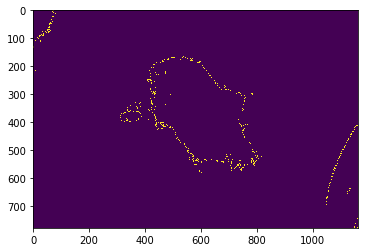

In [34]:
#test_ = cv2.convertScaleAbs(test)
bilateral_filtered_image = cv2.bilateralFilter(test, 5, 175, 175)
edge_detected_image = cv2.Canny(bilateral_filtered_image, 75, 200)
plt.imshow(edge_detected_image)
cnts= cv2.findContours(edge_detected_image.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contour_list = []
for contour in cnts[0]:
    approx = cv2.approxPolyDP(contour,0.01*cv2.arcLength(contour,True),True)
    area = cv2.contourArea(contour)
    if ((len(approx) > 8) & (area > 30) ):
        contour_list.append(contour)
        
cv2.drawContours(test, contour_list,  -1, (255,0,0), 2)
cv2.imshow('Objects Detected',test)
#plt.imshow(contours)

In [ ]:
x, y = [], []

for contour_line in contours:
    for contour in contour_line:
        x.append(contour[0][0])
        y.append(contour[0][1])

x1, x2, y1, y2 = min(x), max(x), min(y), max(y)

cropped = img[y1:y2, x1:x2]

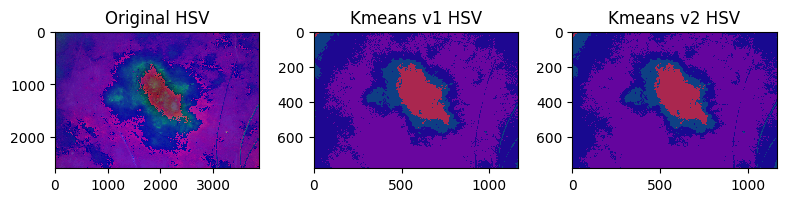

In [37]:
%%time
#plot description
plt.figure(figsize=(8,5),dpi=100)
plt.subplot(1, 3, 1)
img = cv2.imread(test_picture)
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
plt.imshow(hsv)
plt.title("Original HSV")


plt.subplot(1, 3, 2)
test = kmeans_image(test_picture,k=4,resize_ratio=0.3)
hsv = cv2.cvtColor(test, cv2.COLOR_BGR2HSV)
plt.imshow(hsv)

plt.title("Kmeans v1 HSV")


#plot description
plt.subplot(1, 3, 3) 
test = kmeans_image_v2(test_picture,k=4,resize_ratio=0.3)
hsv = cv2.cvtColor(test, cv2.COLOR_BGR2HSV)
plt.imshow(hsv)
plt.tight_layout()
plt.title("Kmeans v2 HSV")
plt.show()




# III. Treat and resize pictures

In [ ]:
%%time
#purge target folder
target  = "../data/resized/"
filelist = [ f for f in os.listdir(target) if f.endswith(".jpg") ]
for f in filelist:
    os.remove(os.path.join(target, f))

In [ ]:
def pad_center(img):
    longer_side = max(img.size)
    horizontal_padding = (longer_side - img.size[0]) / 2
    vertical_padding = (longer_side - img.size[1]) / 2
    img = img.crop(
        (
            -horizontal_padding,
            -vertical_padding,
            img.size[0] + horizontal_padding,
            img.size[1] + vertical_padding
        )
    )
    return img

In [ ]:
def resize(source,target,size):
    dirs = os.listdir(source)
    dirs = [x for x in dirs if ".jpg" in x]
    for item in dirs:
        #print(source+"/"+item)
        im = Image.open(source+"/"+item)
        #f, e = os.path.splitext(source+"/"+item)
        im = pad_center(im)
        imResize = im.resize((size,size), Image.ANTIALIAS)
        imResize.save(target+item, 'JPEG', quality=100)
    return



In [ ]:
files_list = []
for folder in folders:
    dirs = os.listdir("../ISIC-images/"+folder)
    dirs = ["../ISIC-images/"+folder+"/"+x for x in dirs if ".jpg" in x]
    files_list.append(dirs)
    
files_list = [item for sublist in files_list for item in sublist]

In [ ]:
%%time

import multiprocessing as mp
import datetime

size = 299
target = "../data/resized/"

def resize_(file_name):
    #print(source+"/"+item)
    im = Image.open(file_name)
    #f, e = os.path.splitext(file_name)
    im = pad_center(im)
    imResize = im.resize((size,size), Image.ANTIALIAS)
    item = file_name.split("/")[3]
    imResize.save(target+item, 'JPEG', quality=100)
    return 



try:
    pool = mp.Pool(processes=8)
    start_time=datetime.datetime.now()
    result = pool.map(resize_,files_list)
    pool.close()
    pool.join()
    elapsed=datetime.datetime.now()-start_time
    print("Done processing in %s" %(elapsed))
except Exception as e:
    print(e)
    pool.close()
    pool.join()
    print('Pool successfuly closed!')

In [ ]:
#resized pictures
temp = os.listdir(main_path+folder)
temp = [x for x in temp if ".jpg" in x]
img = Image.open(main_path+folder+"/"+temp[4])
plt.imshow(img)


In [ ]:
temp = os.listdir(main_path+folder)
temp = [x for x in temp if ".jpg" in x]
img = Image.open("../data/resized/"+temp[4])
plt.imshow(img)    

**Warning : ** resizing pictures deform images? except if padding

In [ ]:
#control
target  = "../data/resized/"
filelist = [ f for f in os.listdir(target) if f.endswith(".jpg") ]

len(meta) == len(filelist)

In [ ]:
print(len(meta))
print(len(filelist))

# III. Split into train and test